In [ ]:
"""
Calculating convergence of mass and chlorophyll using metpy

N.B. See current estimate documentation 
https://podaac.jpl.nasa.gov/dataset/OSCAR_L4_OC_INTERIM_V2.0
Suggests don't trust values within 100 km of the coast
Current estimate scheme different at -5 to +5km, hence weird looking artifact
"""

In [3]:
pip install cmocean -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install metpy -q

Note: you may need to restart the kernel to use updated packages.


In [13]:
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import holoviews as hv
import hvplot.xarray
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import metpy
import numpy as np
import pandas as pd
import xarray as xr

In [199]:
def calculate_divergence(ds, t_start=False, t_end=False, scale_var=False):
    """
    Inputs:
    ds --> e.g. ds = xr.open_zarr("~/shared-public/mind_the_chl_gap/IO.zarr")
    tstart --> e.g. '2000-01-01'
    tend --> e.g. '2000-12-31'
    scale_var --> Use "CHL" if want CHL flux divergence, leave false for regular divergence

    Outputs:
    divergence --> data array. haven't figured out what units metpy spits it out in.
    """
    u_curr = ds['u_curr'].sel(time=slice(t_start, t_end))
    v_curr = ds['v_curr'].sel(time=slice(t_start, t_end))
    
    u_curr = u_curr.where(u_curr.notnull(), 0)
    v_curr = v_curr.where(v_curr.notnull(), 0)

    if scale_var:
        scale = ds[scale_var].sel(time=slice(t_start, t_end))
        u_curr = u_curr * scale
        v_curr = v_curr * scale
    
    divergence = metpy.calc.divergence(
        u_curr,
        v_curr,
    )

    return divergence

In [218]:
def calculate_divergence_climatology(ds, month=False, scale_var=False):
    """
    month = int (1-12)
    """
    u_curr = ds['u_curr'].groupby("time.month")[month]
    v_curr = ds['v_curr'].groupby("time.month")[month]

    u_curr = u_curr.where(u_curr.notnull(), 0)
    v_curr = v_curr.where(v_curr.notnull(), 0)

    if scale_var:
        scale = ds[scale_var].groupby("time.month")[month]
        u_curr = u_curr * scale
        v_curr = v_curr * scale
    
    u_curr = u_curr.mean("time")
    v_curr = v_curr.mean("time")
    
    divergence = metpy.calc.divergence(
        u_curr,
        v_curr,
    )

    return divergence

In [200]:
def caculate_chl_delta(ds, t_start=False, t_end=False):
    """
    I'm like 80-85% sure this is gets what we want...
    """
    chl = ds['CHL'].sel(time=slice(t_start, t_end))
    chl_delta = chl.diff('time')
    
    return chl_delta

In [ ]:
ds = xr.open_zarr("~/shared-public/mind_the_chl_gap/IO.zarr")

CPU times: user 1min 58s, sys: 13.1 s, total: 2min 11s
Wall time: 46 s


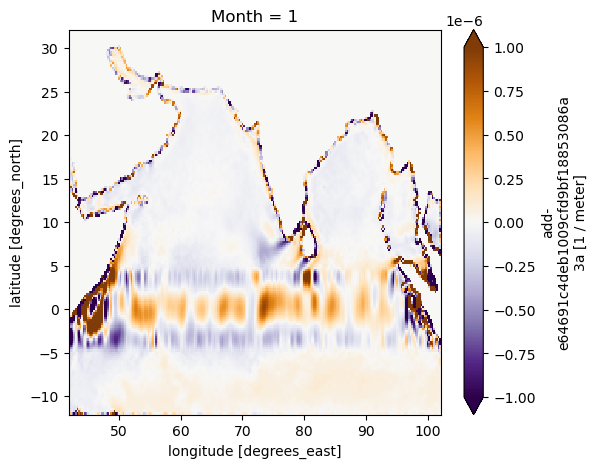

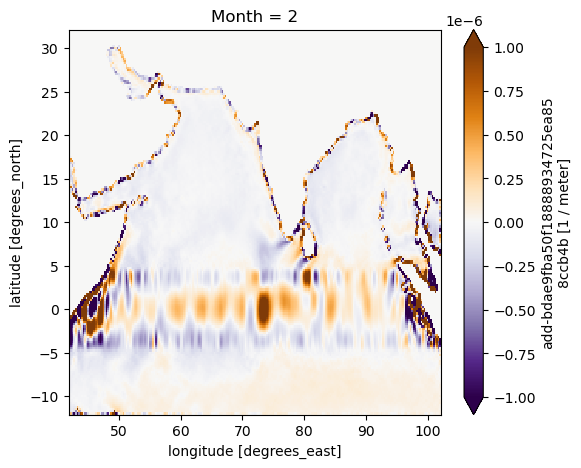

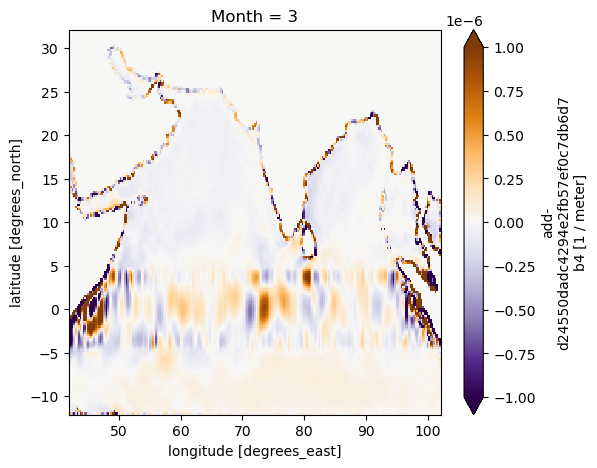

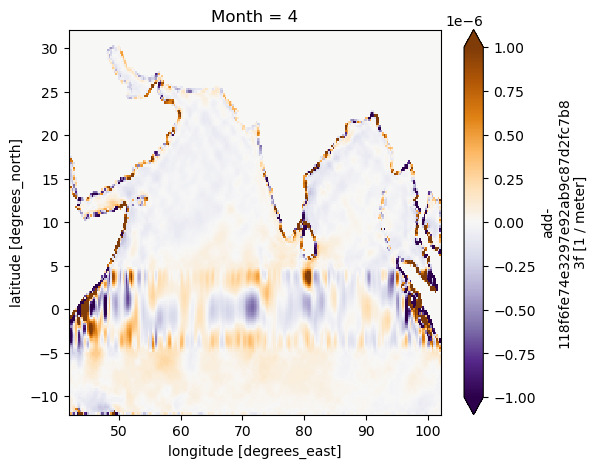

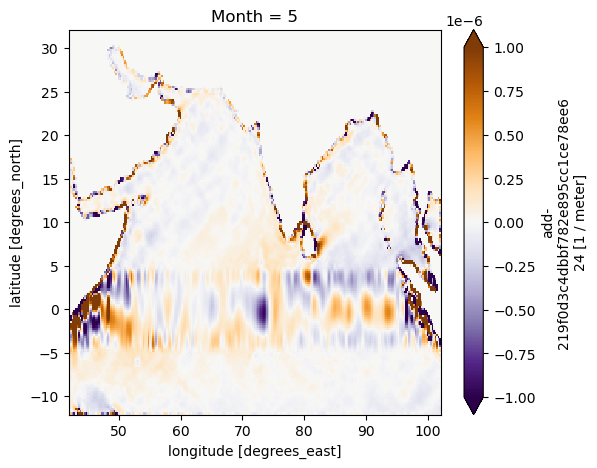

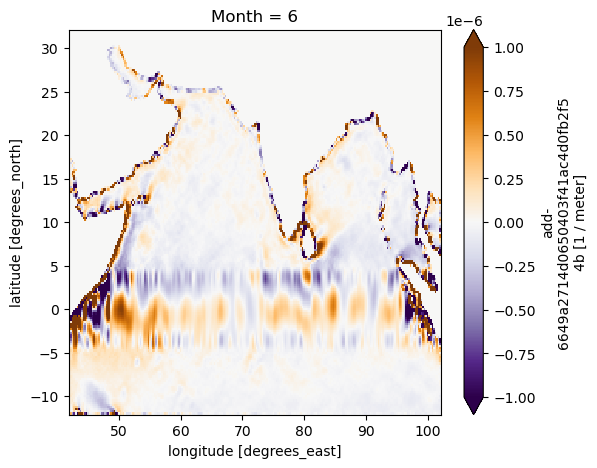

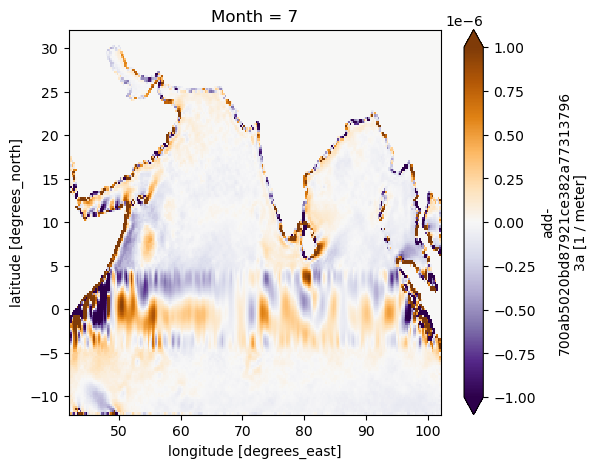

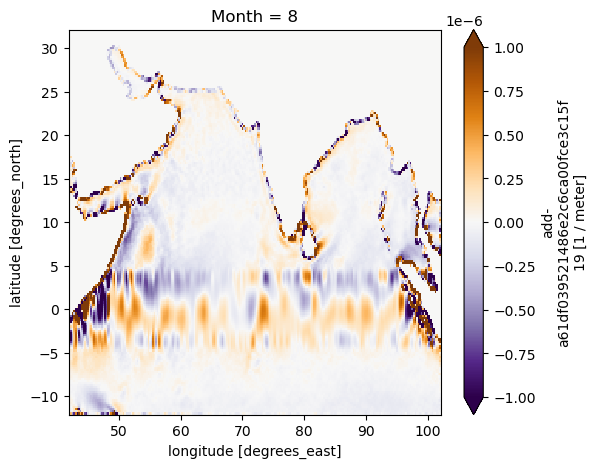

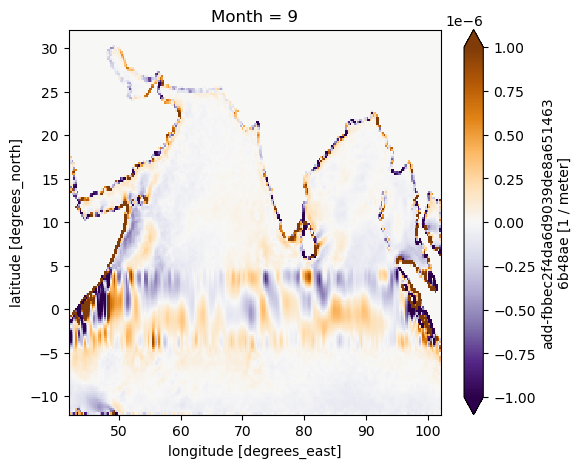

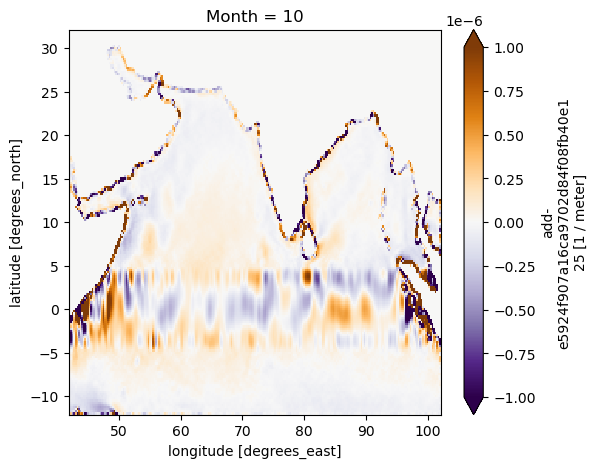

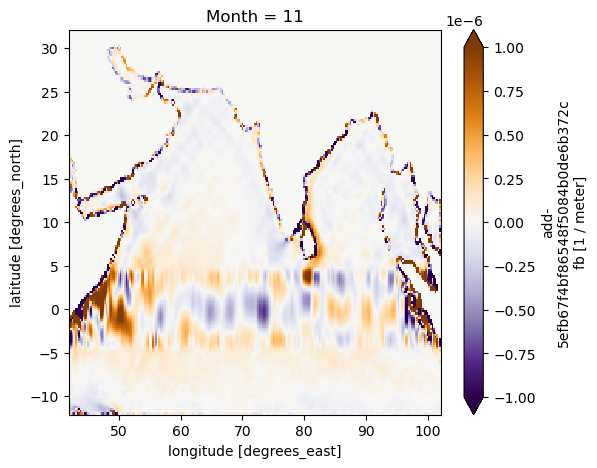

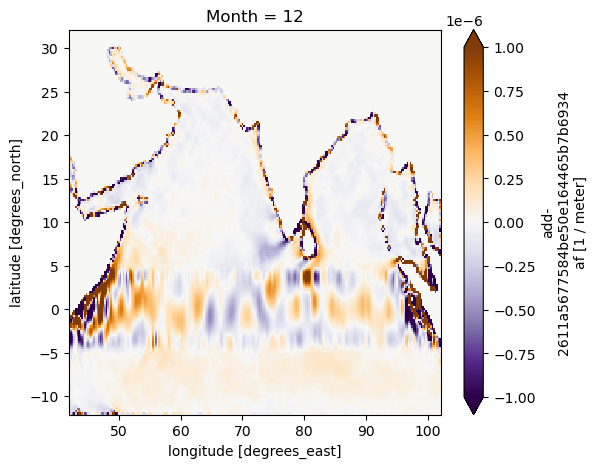

In [219]:
%%time
for i in range(1,12+1):
    fig, ax = plt.subplots(figsize=(6, 5))
    divergence = calculate_divergence_climatology(ds, month=i)
    divergence.plot(vmin=-0.000001, vmax=0.000001, cmap="PuOr_r")
    plt.title(f"Month = {i}")

CPU times: user 3min 16s, sys: 23.5 s, total: 3min 40s
Wall time: 1min 17s


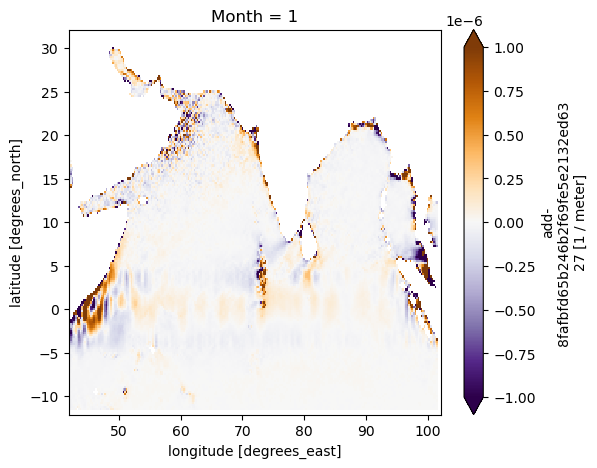

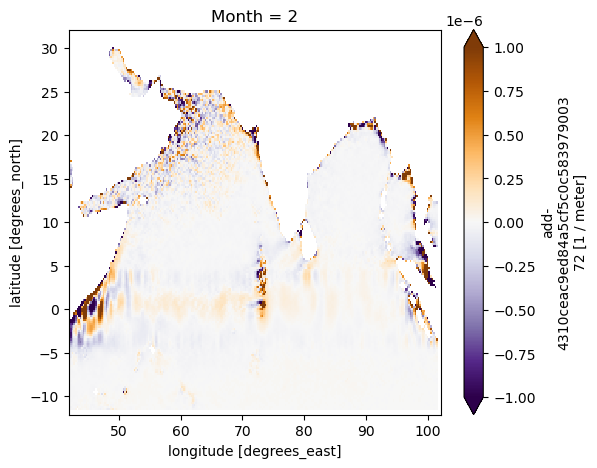

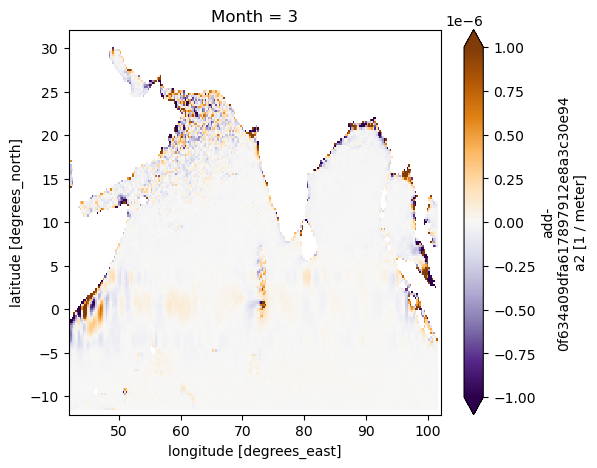

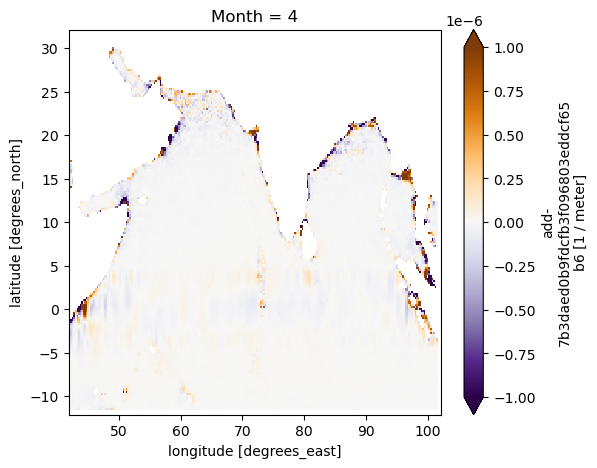

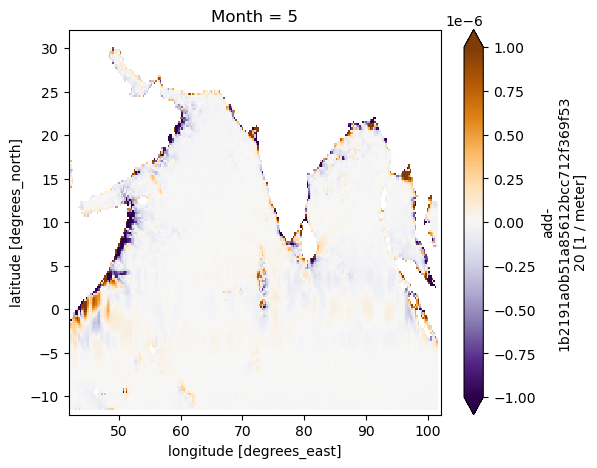

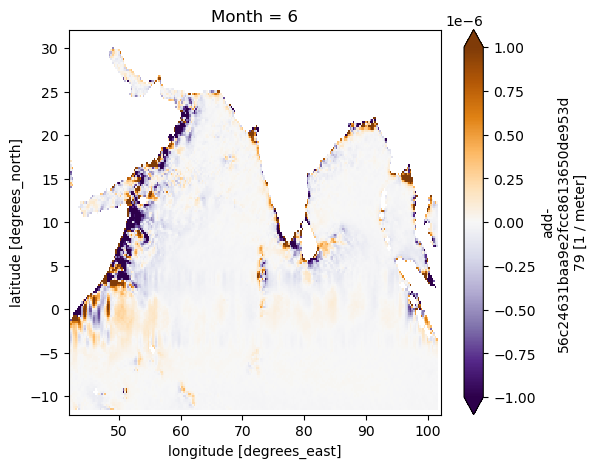

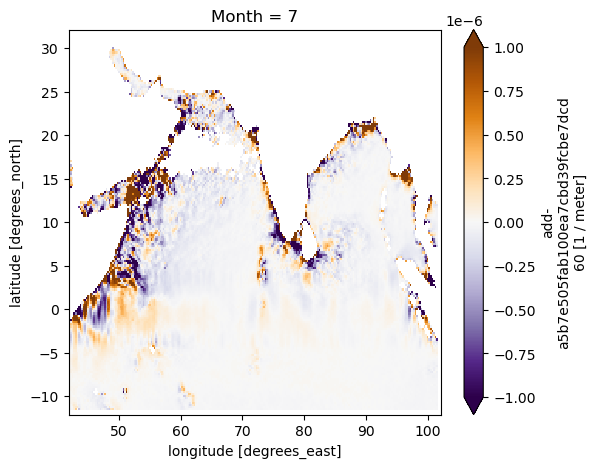

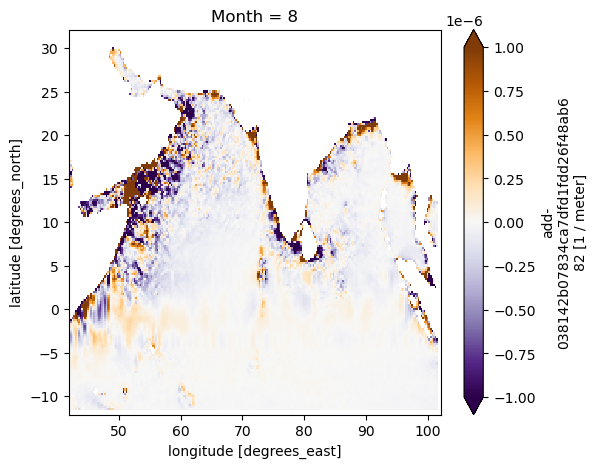

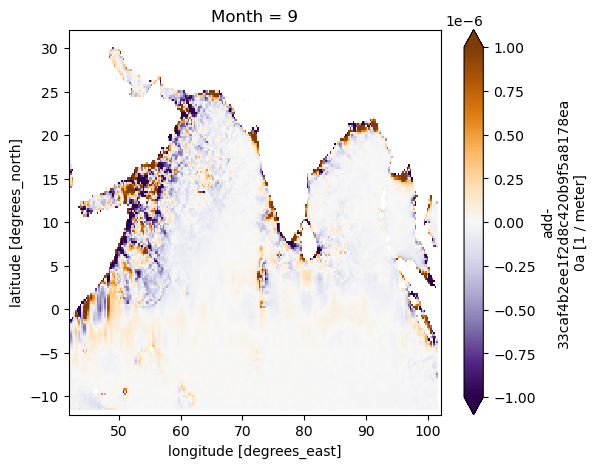

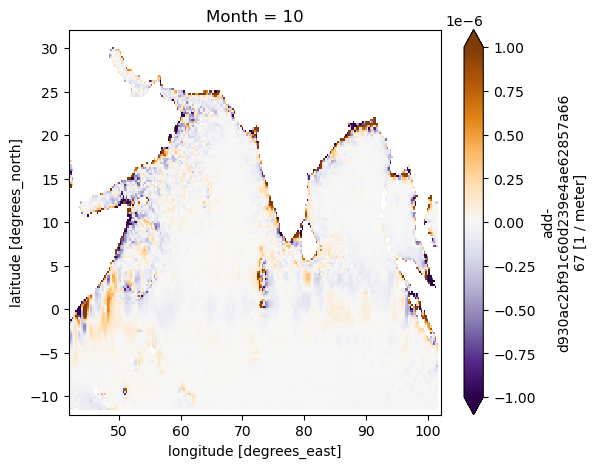

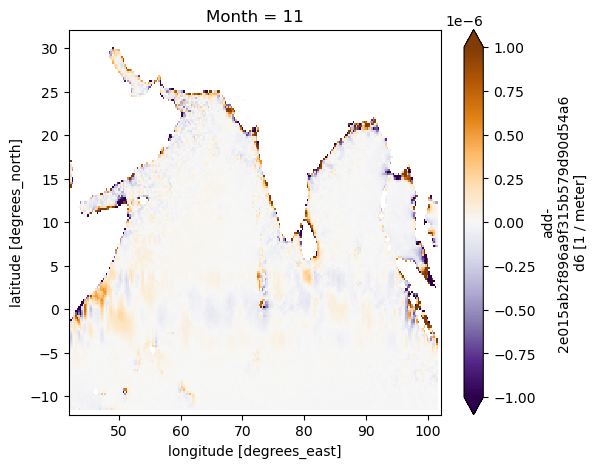

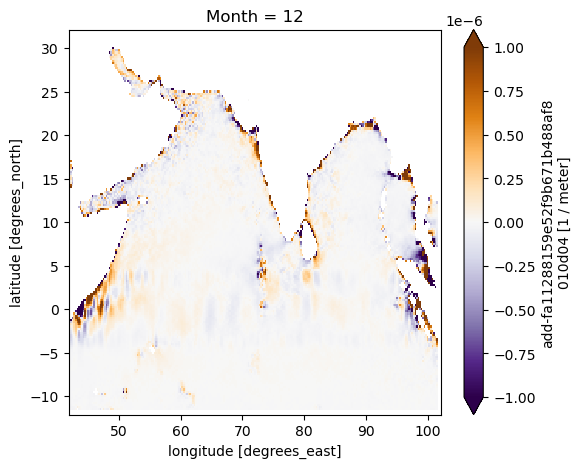

In [220]:
%%time
for i in range(1,12+1):
    fig, ax = plt.subplots(figsize=(6, 5))
    divergence = calculate_divergence_climatology(ds, month=i, scale_var="CHL")
    divergence.plot(vmin=-0.000001, vmax=0.000001, cmap="PuOr_r")
    plt.title(f"Month = {i}")

In [221]:
tstart = '2000-01-01'
tend = '2000-12-31'

divergence = calculate_divergence(ds, tstart, tend)
divergence_chl = calculate_divergence(ds, tstart, tend, scale_var='CHL')
chl_delta = caculate_chl_delta(ds, tstart, tend)

In [222]:
# Dropping last time so chl_delta matches shape of divergences
# Not 100% sure this is right...
if divergence.shape != chl_delta.shape:
    divergence = divergence.isel(time=slice(0, -1))
if divergence_chl.shape != chl_delta.shape:
    divergence_chl = divergence_chl.isel(time=slice(0, -1))

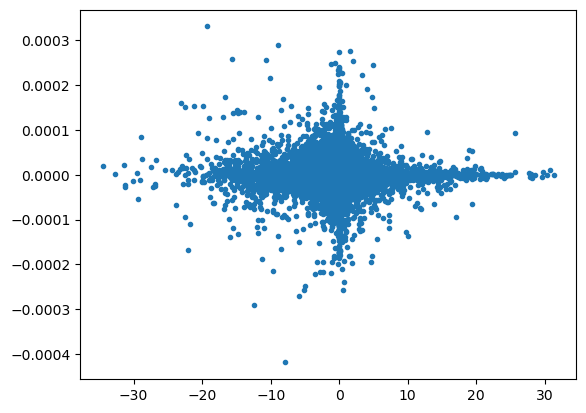

In [223]:
plt.plot(chl_delta[:,:,:].values.flatten(), divergence_chl[:,:,:].values.flatten(), '.')

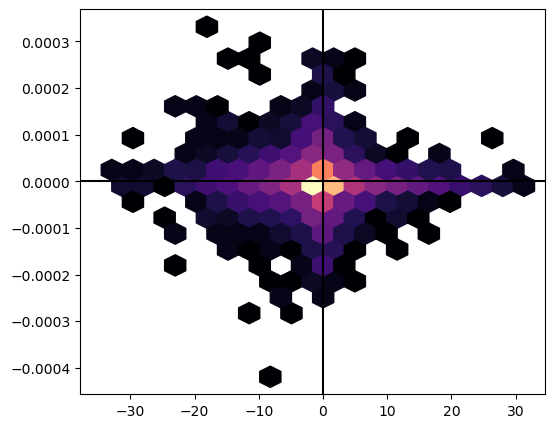

In [224]:
fig, ax = plt.subplots(figsize=(6, 5))
hb = ax.hexbin(chl_delta[:,:,:].values.flatten(),
               divergence_chl[:,:,:].values.flatten(),
               gridsize=20, bins='log', cmap='magma')
ax.axhline(0, color='k')
ax.axvline(0, color='k')

In [229]:
print( xr.corr(chl_delta, divergence_chl).values )

-0.02427103814482843


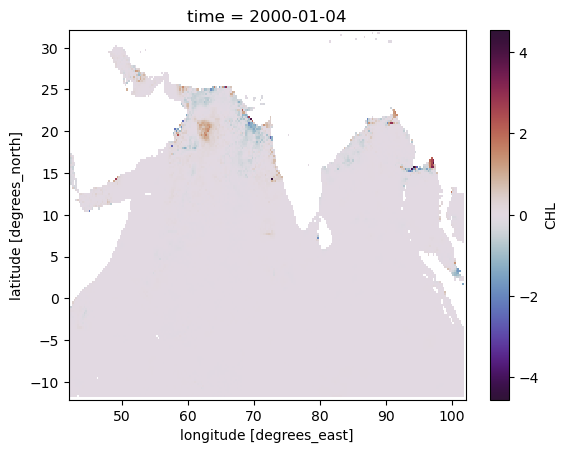

In [226]:
chl_delta[2,:,:].plot(cmap='twilight_shifted')

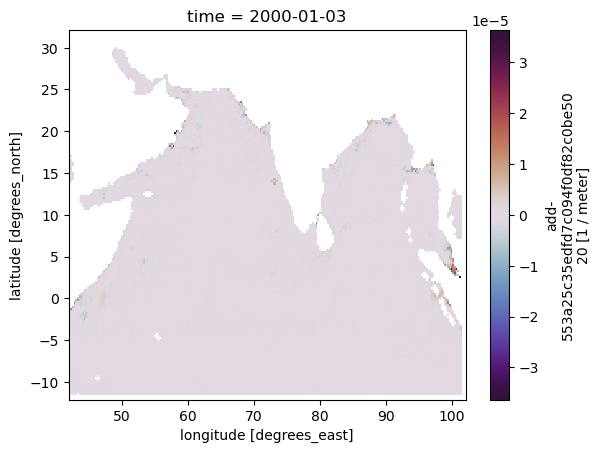

In [227]:
divergence_chl[2,:,:].plot(cmap='twilight_shifted')

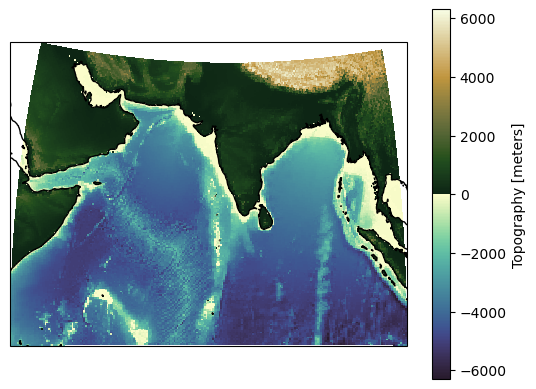

In [228]:
projection = ccrs.Stereographic(central_longitude=75., central_latitude=10.)
ax = ds.topo.plot(transform=ccrs.PlateCarree(), 
                                     subplot_kws=dict(projection=projection),
                                     cmap=cmocean.cm.topo)
ax.axes.coastlines();